### Cleaning DUV data


https://statistik.d-u-v.org/getresulteventalltime.php?event=25042

DUV data contains each runners Year of Birth (YOB)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata

In [2]:
# Function to remove special characters
def normalize_name(name):
    # Normalize to remove accents and special characters
    name = unicodedata.normalize('NFD', name)
    # Encode to ASCII and ignore errors, then decode back to string
    name = name.encode('ascii', 'ignore').decode('utf-8')
    return name

In [3]:
TORX_duv_dict = {}

races = ['TOR330', 'TOR450']

for race in races:
    file = f'{race} Data/DUV/{race}_multiple.xlsx'
    df = pd.read_excel(file)

    df = df[['Name', 'Nat.', 'M/F', 'YOB', 'Date','Performance' ]]

    # renaming columns so it is easier later to compare
    df = df.rename(columns={"Nat.": "DUV_ationality",
                            "M/F": "Sex",
                            }) 
    

    ##########################################
    
    # When read in, YOB is a number, needs to be changed to a string
    df['YOB'] = df['YOB'].astype('str')    

    ##########################################

    for column in df.columns:
        # Clean up the 'Name' column by stripping leading/trailing spaces and non-breaking spaces
        df[column] = df[column].str.strip()
        df[column] = df[column].str.replace(',', '')
        df[column] = df[column].str.replace('\'', ' ')


    # dropping all irregular letters like in Spanish
    df['Name'] = df['Name'].apply(normalize_name)
    # Title Case
    df['Name'] = df['Name'].str.title()

    ##########################################
    # Assuming Date format like "08.-14.09.2019"
    df[['Start Day', 'End Day', 'Month', 'Year']] = df['Date'].str.extract(r'(\d{2})\.-(\d{2})\.(\d{2})\.(\d{4})')

    if race == 'TOR450':
        df['Start Date'] = df['Year'] + '.' + df['Month'] + '.' + df['Start Day'] + ' 20:00:00'

    else:
        # sweeping assumption that TOR330 starts at 10am
        df['Start Date'] = df['Year'] + '.' + df['Month'] + '.' + df['Start Day'] + ' 10:00:00'
    # Combine them into desired Start Date and End Date format if needed

#     print(df['Start Date'].unique())

    df['Start Date'] = pd.to_datetime(df['Start Date'])

    ##########################################
    # Race 
    df['Race'] = f'{race}'

    ##########################################
    # changing the performance to a timedelta
    df['Performance'] = pd.to_timedelta(df['Performance'], errors='coerce')
    #finding out the time that participants finished so the dataset could be used in Tableau
    df['Finish Time for Tableau'] = df['Start Date'] + df['Performance']  
#     print(df.head())

    ##########################################
    # Create 'DOB' column by adding '01/01/' prefix to 'YOB'
    df['DOB'] = '01/01/' + df['YOB'].astype(str)

    # Replace '01/01/' without a following year with NaN
    df['DOB'] = df['DOB'].replace(r'^01/01/$', np.nan, regex=True)

    # Convert to datetime, with errors='coerce' to handle NaT cases
    df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')


    # Drop the intermediate columns if they're no longer needed
    df = df.drop(columns=['Start Day', 'End Day', 'Month', 'Date', 'YOB'])


    TORX_duv_dict[f'{race}_duv'] = df
    print(f'{race} DUV data was read in ')

TOR330 DUV data was read in 
TOR450 DUV data was read in 


In [4]:
# Append using pd.concat
TORX_duv_df = pd.concat(TORX_duv_dict)

TORX_duv_df = TORX_duv_df[[
    'Name', 'DUV_ationality', 'Sex',  'DOB', 
    'Start Date', 'Finish Time for Tableau','Performance', 
    'Race', 'Year',
#         'Race_Year', 'Performance_Race'
]].reset_index(drop = True)


TORX_duv_df[TORX_duv_df['Name'].str.contains('D Haene Francois')]

,Name,DUV_ationality,Sex,DOB,Start Date,Finish Time for Tableau,Performance,Race,Year
4,D Haene Francois,FRA,M,1985-01-01,2024-09-08 10:00:00,2024-09-11 07:08:32,2 days 21:08:32,TOR330,2024


In [5]:


# # Save the result
TORX_duv_df.to_excel(f'Database Data/TORX_duv_df.xlsx' , index = False)

TORX_duv_df

,Name,DUV_ationality,Sex,DOB,Start Date,Finish Time for Tableau,Performance,Race,Year
0,Colle Franco Leo,ITA,M,1978-01-01,2023-09-10 10:00:00,2023-09-13 04:39:16,2 days 18:39:16,TOR330,2023
1,Colle Franco Leo,ITA,M,1978-01-01,2021-09-12 10:00:00,2021-09-15 04:43:57,2 days 18:43:57,TOR330,2021
2,Dominguez Ledo Javier,ESP,M,1974-01-01,2017-09-10 10:00:00,2017-09-13 05:52:15,2 days 19:52:15,TOR330,2017
3,Russi Jonas,SUI,M,1985-01-01,2021-09-12 10:00:00,2021-09-15 07:03:00,2 days 21:03:00,TOR330,2021
4,D Haene Francois,FRA,M,1985-01-01,2024-09-08 10:00:00,2024-09-11 07:08:32,2 days 21:08:32,TOR330,2024
...,...,...,...,...,...,...,...,...,...
5649,Giacchetta Stephane,BEL,M,1975-01-01,2024-09-06 20:00:00,2024-09-14 16:31:46,7 days 20:31:46,TOR450,2024
5650,Rubaldo Paolo,ITA,M,1971-01-01,2019-09-06 20:00:00,2019-09-14 16:32:40,7 days 20:32:40,TOR450,2019
5651,Guffon Alain,FRA,M,1968-01-01,2023-09-08 20:00:00,2023-09-16 16:43:07,7 days 20:43:07,TOR450,2023
5652,Gay Jean-Philippe,FRA,M,1974-01-01,2023-09-08 20:00:00,2023-09-16 17:18:00,7 days 21:18:00,TOR450,2023


### Extracting Start Date so can be used for other Datasets

In [6]:

TORX_date_info_df = TORX_duv_df[[
    'Race', 'Year',
    'Start Date',
    
]].copy()

# Dropping all redundant rows
TORX_date_info_df.drop_duplicates( keep='first', inplace=True, ignore_index=False)


# Extract the day of the week
TORX_date_info_df['Day_of_Week Start_Date'] = TORX_date_info_df['Start Date'].dt.day_name()

TORX_date_info_df = TORX_date_info_df.reset_index(drop= True)

print(TORX_date_info_df[['Race', 'Year', 'Start Date', 'Day_of_Week Start_Date']])

TORX_date_info_df.to_excel(f'Database Data/TORX_duv_dates_df.xlsx' , index = False)


      Race  Year          Start Date Day_of_Week Start_Date
0   TOR330  2023 2023-09-10 10:00:00                 Sunday
1   TOR330  2021 2021-09-12 10:00:00                 Sunday
2   TOR330  2017 2017-09-10 10:00:00                 Sunday
3   TOR330  2024 2024-09-08 10:00:00                 Sunday
4   TOR330  2013 2013-09-08 10:00:00                 Sunday
5   TOR330  2022 2022-09-11 10:00:00                 Sunday
6   TOR330  2014 2014-09-07 10:00:00                 Sunday
7   TOR330  2019 2019-09-08 10:00:00                 Sunday
8   TOR330  2018 2018-09-09 10:00:00                 Sunday
9   TOR330  2016 2016-09-11 10:00:00                 Sunday
10  TOR330  2012 2012-09-09 10:00:00                 Sunday
11  TOR330  2011 2011-09-11 10:00:00                 Sunday
12  TOR330  2015 2015-09-13 10:00:00                 Sunday
13  TOR330  2010 2010-09-12 10:00:00                 Sunday
14  TOR450  2023 2023-09-08 20:00:00                 Friday
15  TOR450  2024 2024-09-06 20:00:00    

In [7]:
TORX_duv_df[TORX_duv_df['Name'].str.contains('Colle Franco')]

,Name,DUV_ationality,Sex,DOB,Start Date,Finish Time for Tableau,Performance,Race,Year
0,Colle Franco Leo,ITA,M,1978-01-01,2023-09-10 10:00:00,2023-09-13 04:39:16,2 days 18:39:16,TOR330,2023
1,Colle Franco Leo,ITA,M,1978-01-01,2021-09-12 10:00:00,2021-09-15 04:43:57,2 days 18:43:57,TOR330,2021
11,Colle Franco Leo,ITA,M,1978-01-01,2014-09-07 10:00:00,2014-09-10 09:49:10,2 days 23:49:10,TOR330,2014
13,Colle Franco Leo,ITA,M,1978-01-01,2013-09-08 10:00:00,2013-09-11 10:05:23,3 days 00:05:23,TOR330,2013
18,Colle Franco Leo,ITA,M,1978-01-01,2018-09-09 10:00:00,2018-09-12 12:03:00,3 days 02:03:00,TOR330,2018
85,Colle Franco Leo,ITA,M,1978-01-01,2012-09-09 10:00:00,2012-09-12 22:15:59,3 days 12:15:59,TOR330,2012


In [8]:
# Combine 'Performance' and 'Race' into a single column
TORX_duv_df['Performance_Race'] = TORX_duv_df['Performance'].astype('str') + " " + TORX_duv_df['Race']

# Pivot the DataFrame
TORX_duv_pivot_df = TORX_duv_df.pivot(index='Name', columns='Year', values='Performance_Race')

# Fill missing values with "-"
TORX_duv_pivot_df = TORX_duv_pivot_df.fillna('-')

# Reset the index to make 'Name' a column again
TORX_duv_pivot_df = TORX_duv_pivot_df.reset_index()

# Save the result
# TORX_duv_pivot_df.to_excel(f'Database Data/TORX_duv_pivot_df.xlsx' , index = False)

TORX_duv_pivot_df

Year,Name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023,2024
0,Aakre Eivind,-,-,-,-,-,-,-,-,6 days 00:45:33 TOR330,-,-,-,-,-
1,Aarons Jamie,-,-,-,-,-,-,5 days 11:26:21 TOR330,-,3 days 23:54:35 TOR330,-,-,-,-,-
2,Abanera Luca,-,-,-,-,-,-,6 days 01:48:21 TOR330,-,5 days 07:52:29 TOR330,-,-,-,-,-
3,Abate Francesco,-,-,-,5 days 05:52:57 TOR330,-,-,5 days 05:03:29 TOR330,-,-,-,-,-,-,-
4,Abbate Mauro,-,-,-,-,-,-,-,-,-,4 days 21:40:07 TOR330,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4180,Zucconi Francesco,-,-,4 days 13:39:31 TOR330,-,-,-,-,-,-,-,-,-,-,-
4181,Zumeta Artola Garikoitz,-,-,-,-,-,-,5 days 04:20:05 TOR330,-,-,-,-,-,-,-
4182,Zuncheddu Matteo,-,-,-,-,-,-,-,-,5 days 04:11:59 TOR330,-,-,-,-,-
4183,Zurita Gimeno Nacho,-,-,-,-,-,-,-,-,-,-,-,-,-,4 days 12:51:28 TOR330


#### Examining Histograms of TOR330 and TOR450

In [15]:
tor330_duv = TORX_duv_df[TORX_duv_df['Race'] == 'TOR330']

tor450_duv = TORX_duv_df[TORX_duv_df['Race'] == 'TOR450']

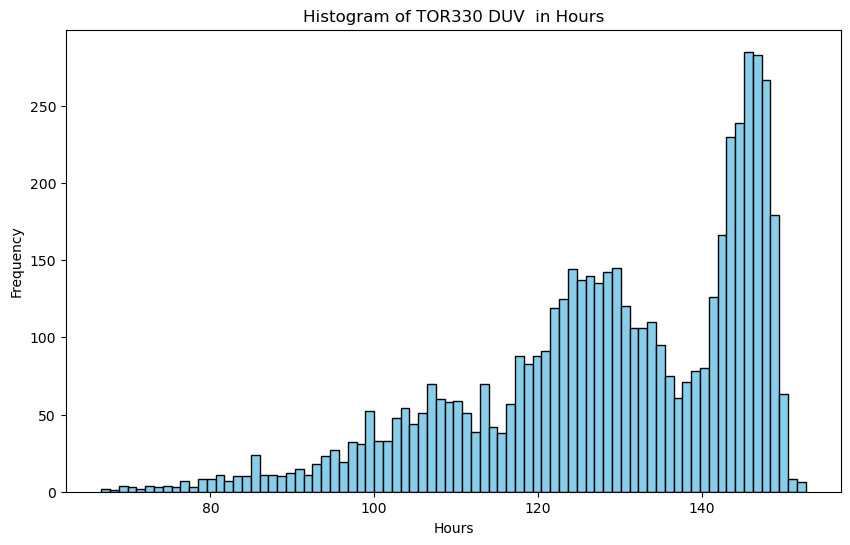

In [16]:
# Create the hour list
hour_list = [t.total_seconds() / 3600 for t in tor330_duv['Performance']]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(hour_list, bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of TOR330 DUV  in Hours')
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.show()

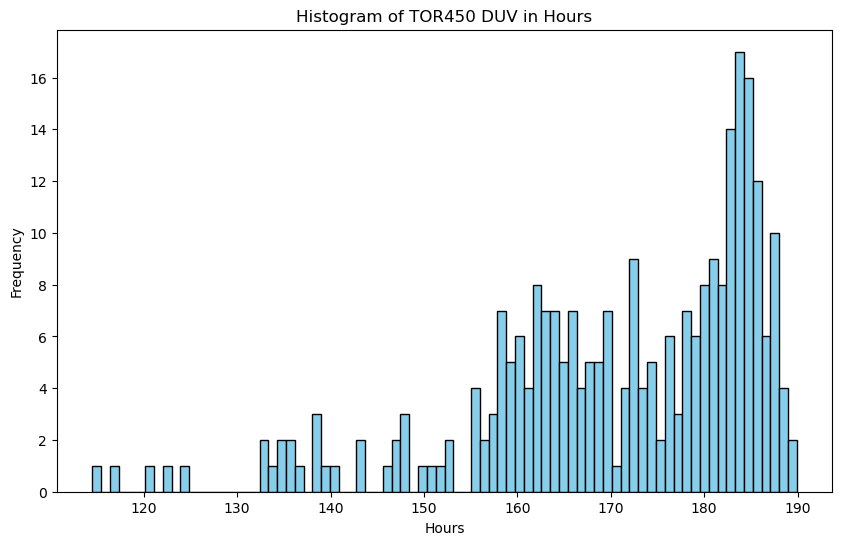

In [17]:
# Create the hour list
hour_list = [t.total_seconds() / 3600 for t in tor450_duv['Performance']]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(hour_list, bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of TOR450 DUV in Hours')
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.show()

### Extracting Demographic Info of all runners who FINISHED TOR330 

In [18]:
# # Selecting the columns
# demographics_TORX_duv_df = TORX_duvf[['Name', 'Nationality', 'Sex', 'YOB']].copy()

# # Dropping all redundant rows
# demographics_TORX_duv_df.drop_duplicates( keep='first', inplace=True, ignore_index=False)


# # finding Paul Tierney
# demographics_TORX_duv_df[demographics_TORX_duv_df['Name'].str.contains('Tierney Paul')]

### Qualifying times for TOR450

In [19]:
finisher_qualifying_times_list = []

### Grabbing List of TOR 450 Finishers
tor450_duv_finishers = tor450_duv['Name'].unique()

for finisher in tor450_duv_finishers:
    finisher_TORX_duv_df = TORX_duv_df[TORX_duv_df['Name'] ==  finisher]
    finisher_qualifying_times_list.append(finisher_TORX_duv_df)
    
finisher_qualifying_times_df = pd.concat(finisher_qualifying_times_list)
finisher_qualifying_times_df.reset_index(drop=True)

,Name,DUV_ationality,Sex,DOB,Start Date,Finish Time for Tableau,Performance,Race,Year,Performance_Race
0,Raichon Sebastien,FRA,M,1972-01-01,2019-09-08 10:00:00,2019-09-12 00:25:33,3 days 14:25:33,TOR330,2019,3 days 14:25:33 TOR330
1,Raichon Sebastien,FRA,M,1972-01-01,2023-09-08 20:00:00,2023-09-13 14:29:01,4 days 18:29:01,TOR450,2023,4 days 18:29:01 TOR450
2,Raichon Sebastien,FRA,M,1972-01-01,2022-09-09 20:00:00,2022-09-14 23:57:18,5 days 03:57:18,TOR450,2022,5 days 03:57:18 TOR450
3,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,2019-09-08 10:00:00,2019-09-11 18:18:24,3 days 08:18:24,TOR330,2019,3 days 08:18:24 TOR330
4,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,2018-09-09 10:00:00,2018-09-13 17:23:07,4 days 07:23:07,TOR330,2018,4 days 07:23:07 TOR330
...,...,...,...,...,...,...,...,...,...,...
605,Guffon Alain,FRA,M,1968-01-01,2023-09-08 20:00:00,2023-09-16 16:43:07,7 days 20:43:07,TOR450,2023,7 days 20:43:07 TOR450
606,Gay Jean-Philippe,FRA,M,1974-01-01,2019-09-08 10:00:00,2019-09-13 12:33:05,5 days 02:33:05,TOR330,2019,5 days 02:33:05 TOR330
607,Gay Jean-Philippe,FRA,M,1974-01-01,2023-09-08 20:00:00,2023-09-16 17:18:00,7 days 21:18:00,TOR450,2023,7 days 21:18:00 TOR450
608,Shao Sebastien,FRA,M,1974-01-01,2022-09-11 10:00:00,2022-09-16 12:35:05,5 days 02:35:05,TOR330,2022,5 days 02:35:05 TOR330


In [20]:
finisher_qualifying_times_df[finisher_qualifying_times_df['Name'] == 'Tierney Paul']

,Name,DUV_ationality,Sex,DOB,Start Date,Finish Time for Tableau,Performance,Race,Year,Performance_Race
135,Tierney Paul,IRL,M,1982-01-01,2021-09-12 10:00:00,2021-09-16 02:05:51,3 days 16:05:51,TOR330,2021,3 days 16:05:51 TOR330
226,Tierney Paul,IRL,M,1982-01-01,2018-09-09 10:00:00,2018-09-13 08:39:26,3 days 22:39:26,TOR330,2018,3 days 22:39:26 TOR330
340,Tierney Paul,IRL,M,1982-01-01,2017-09-10 10:00:00,2017-09-14 13:09:44,4 days 03:09:44,TOR330,2017,4 days 03:09:44 TOR330
5395,Tierney Paul,IRL,M,1982-01-01,2023-09-08 20:00:00,2023-09-14 11:22:00,5 days 15:22:00,TOR450,2023,5 days 15:22:00 TOR450
5396,Tierney Paul,IRL,M,1982-01-01,2022-09-09 20:00:00,2022-09-15 12:23:20,5 days 16:23:20,TOR450,2022,5 days 16:23:20 TOR450


In [21]:
# Combine 'Performance' and 'Race' into a single column
finisher_qualifying_times_df['Performance_Race'] = finisher_qualifying_times_df['Performance'].astype('str') + " " + finisher_qualifying_times_df['Race']

# Pivot the DataFrame
finisher_qualifying_times_df_pivot = finisher_qualifying_times_df.pivot(index='Name', columns='Year', values='Performance_Race')

# Fill missing values with "-"
finisher_qualifying_times_df_pivot = finisher_qualifying_times_df_pivot.fillna('-')

# Reset the index to make 'Name' a column again
finisher_qualifying_times_df_pivot = finisher_qualifying_times_df_pivot.reset_index()

# Print the result
# finisher_qualifying_times_df_pivot.to_excel(f'Database Data/finisher_qualifying_times_df_pivot.xlsx' , index = False)

finisher_qualifying_times_df_pivot


Year,Name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023,2024
0,Adam Eric,-,-,-,-,-,-,-,-,-,-,5 days 03:17:13 TOR330,7 days 13:01:00 TOR450,-,-
1,Adet Benoit,-,-,-,-,-,-,-,-,-,5 days 13:55:36 TOR330,5 days 08:37:35 TOR330,-,-,7 days 17:30:35 TOR450
2,Ador Thierry,-,-,-,-,-,-,-,4 days 06:36:56 TOR330,3 days 21:31:37 TOR330,-,-,-,-,6 days 15:08:45 TOR450
3,Alfero Flavien,-,-,-,-,-,-,-,-,-,-,-,4 days 12:51:00 TOR330,6 days 15:48:26 TOR450,-
4,Alvarez Perez Miguel,-,-,4 days 14:04:38 TOR330,-,4 days 03:15:31 TOR330,-,-,-,-,-,6 days 20:20:51 TOR450,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Wang Xiao-Lin,-,-,-,-,5 days 12:15:02 TOR330,-,4 days 05:55:11 TOR330,-,3 days 23:44:12 TOR330,-,-,-,6 days 16:26:08 TOR450,7 days 00:46:46 TOR450
211,Wendling Vincent,-,-,-,-,-,-,-,-,5 days 02:30:17 TOR330,4 days 19:56:02 TOR330,7 days 18:50:41 TOR450,-,-,-
212,Xiong Peng-Peng,-,-,-,-,-,-,-,-,-,5 days 00:52:39 TOR330,-,-,7 days 15:41:10 TOR450,-
213,Zanarella Cristiano,-,-,-,-,-,-,-,-,5 days 00:38:28 TOR330,6 days 22:35:28 TOR450,-,-,-,-


In [26]:
# All Qualifying Times UNDER 130 hours
# 5 days 10:00:0

# 150 hours = 6 days 06:00:00:00
qualifying_times_under_130_hours_df = finisher_qualifying_times_df[finisher_qualifying_times_df['Performance'] < pd.to_timedelta('5 days 10:00:0')]
qualifying_times_under_130_hours_df.head()

,Name,DUV_ationality,Sex,DOB,Start Date,Finish Time for Tableau,Performance,Race,Year,Performance_Race
118,Raichon Sebastien,FRA,M,1972-01-01,2019-09-08 10:00:00,2019-09-12 00:25:33,3 days 14:25:33,TOR330,2019,3 days 14:25:33 TOR330
5384,Raichon Sebastien,FRA,M,1972-01-01,2023-09-08 20:00:00,2023-09-13 14:29:01,4 days 18:29:01,TOR450,2023,4 days 18:29:01 TOR450
5388,Raichon Sebastien,FRA,M,1972-01-01,2022-09-09 20:00:00,2022-09-14 23:57:18,5 days 03:57:18,TOR450,2022,5 days 03:57:18 TOR450
46,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,2019-09-08 10:00:00,2019-09-11 18:18:24,3 days 08:18:24,TOR330,2019,3 days 08:18:24 TOR330
511,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,2018-09-09 10:00:00,2018-09-13 17:23:07,4 days 07:23:07,TOR330,2018,4 days 07:23:07 TOR330


In [30]:
slowest_qualifying_time = qualifying_times_under_130_hours_df['Performance'].max()

# slowest_qualifying_time = pd.DataFrame(slowest_qualifying_time)
print('The slowest TOR330 that lead to a finishTOR450 was: ', slowest_qualifying_time)

The slowest TOR330 that lead to a finishTOR450 was:  5 days 09:50:48


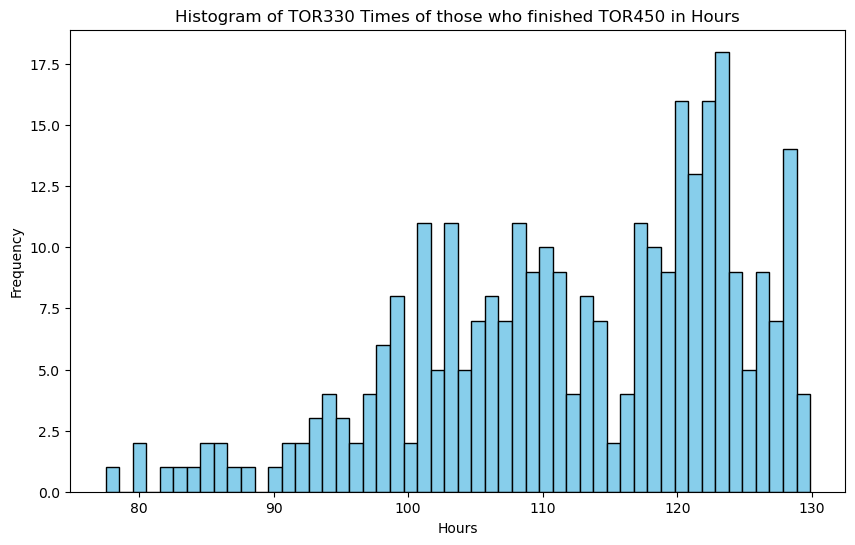

In [32]:
TOR330_itra_finishers_Performance = [t.total_seconds() / 3600 for t in qualifying_times_under_130_hours_df['Performance']]

max_Performance = max(TOR330_itra_finishers_Performance)
min_Performance =  min(TOR330_itra_finishers_Performance)
Performance_bins = int(max_Performance- min_Performance)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(TOR330_itra_finishers_Performance, bins=Performance_bins, color='skyblue', edgecolor='black')
plt.title('Histogram of TOR330 Times of those who finished TOR450 in Hours')
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.show()

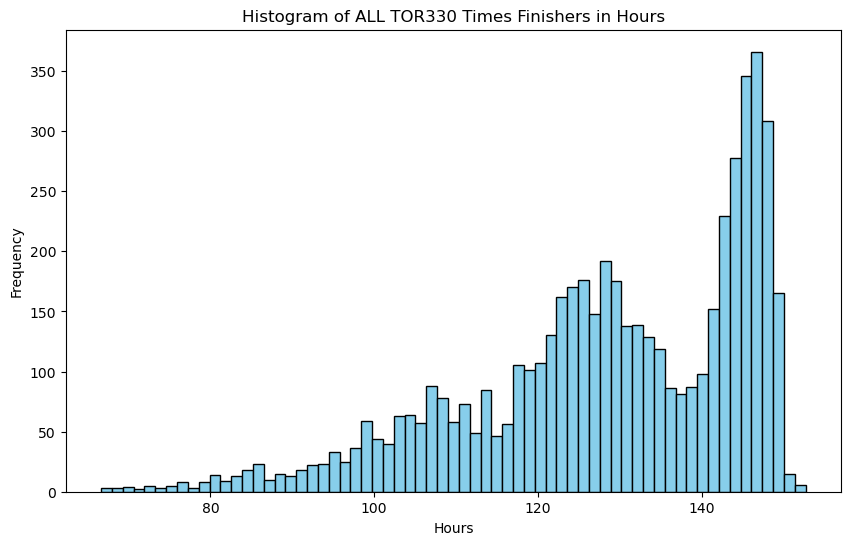

In [33]:
# Create the hour list
hour_list = [t.total_seconds() / 3600 for t in tor330_duv['Performance']]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(hour_list, bins=65, color='skyblue', edgecolor='black')
plt.title('Histogram of ALL TOR330 Times Finishers in Hours')
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.show()